# Coursework 2: Generative Models

## Instructions

Please submit on CATe two zip files:

*CW2.zip* containing the following:
1. A version of this notebook containing your answers. Write your answers in the cells below each question. **Please deliver the notebook including the outputs of the cells below.**
2. Your trained VAE model as *VAE_model.pth*

*GAN.zip* containing your trained Generator and Discriminator: *DCGAN_model_D.pth and DCGAN_model_G.pth*

Please avoid using markdown headings (# ## etc.) as these will affect the ToC. Instead use html headings if you want emphasis.

Similarly to the previous coursework, we recommend that you use Google Colaboratory in order to train the required networks.

TAs will run a testing cell (at the end of this notebook), so you are required to copy your transform and denorm functions to a cell near the bottom of the document (it is demarkated).

<font color="blue">**The deadline for submission is 19:00, Thursday 19th February, 2021** </font>

## Setting up working environment

For this coursework you, will need to train a large network, therefore we recommend you work with Google Colaboratory, which provides free GPU time. You will need a Google account to do so.

Please log in to your account and go to the following page: https://colab.research.google.com. Then upload this notebook.

For GPU support, go to "Edit" -> "Notebook Settings", and select "Hardware accelerator" as "GPU".

You will need to install pytorch and import some utilities by running the following cell:

In [ ]:
!pip install -q torch torchvision
!git clone -q https://github.com/afspies/icl_dl_cw2_utils
from icl_dl_cw2_utils.utils.plotting import plot_tsne
%load_ext google.colab.data_table

fatal: destination path 'icl_dl_cw2_utils' already exists and is not an empty directory.


In [ ]:
from google.colab import drive
drive.mount('/content/drive') # Outputs will be saved in your google drive

ValueError: ignored

## Introduction

For this coursework, you are asked to implement two commonly used generative models:
1. A **Variational Autoencoder (VAE)**
2. A **Deep Convolutional Generative Adversarial Network (DCGAN)**

For the first part you will the MNIST dataset https://en.wikipedia.org/wiki/MNIST_database and for the second the CIFAR-10 (https://www.cs.toronto.edu/~kriz/cifar.html).

Each part is worth 50 points. 

The emphasis of both parts lies in understanding how the models behave and learn, however, some points will be available for getting good results with your GAN (though you should not spend too long on this).

# Part 1 - Variational Autoencoder

## Part 1.1 (25 points)
**Your Task:**

a. Implement the VAE architecture with accompanying hyperparameters. Experiment with Feedforward and Convolutional Layers to see which gives better results.

b. Design an appropriate loss function and train the model.


In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt

def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

if not os.path.exists('/content/drive/MyDrive/icl_dl_cw2/CW_VAE/'):
    os.makedirs('/content/drive/MyDrive/icl_dl_cw2/CW_VAE/')

# We set a random seed to ensure that your results are reproducible.
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

GPU = True # Choose whether to use GPU
if GPU:
    device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(f'Using {device}')

Using cuda


---
## Part 1.1a: Implement VAE (25 Points)
###Hyper-parameter selection


In [ ]:
# Necessary Hyperparameters 
num_epochs = 25
learning_rate = 1e-3
batch_size = 64
latent_dim = 40
# Choose a value for the size of the latent space

# Additional Hyperparameters 


# (Optionally) Modify transformations on input
transform = transforms.Compose([
    transforms.ToTensor(),
])

# (Optionally) Modify the network's output for visualizing your images
vae_denorm = lambda x:x

### Data loading


In [ ]:
train_dat = datasets.MNIST(
    "data/", train=True, download=True, transform=transform
)
test_dat = datasets.MNIST("data/", train=False, transform=transform)

loader_train = DataLoader(train_dat, batch_size, shuffle=True)
loader_test = DataLoader(test_dat, batch_size, shuffle=False)

# Don't change 
sample_inputs, _ = next(iter(loader_test))
fixed_input = sample_inputs[:32, :, :, :]
save_image(fixed_input, '/content/drive/MyDrive/icl_dl_cw2/CW_VAE/image_original.png')

### Model Definition

<figure>
  <img src="https://blog.bayeslabs.co/assets/img/vae-gaussian.png" style="width:60%">
  <figcaption>
    Fig.1 - VAE Diagram (with a Guassian prior), taken from <a href="https://blog.bayeslabs.co/2019/06/04/All-you-need-to-know-about-Vae.html">1</a>.
  </figcaption>
</figure>


You will need to define:
* The hyperparameters
* The constructor
* encode
* reparametrize
* decode
* forward



Hints:
- It is common practice to encode the log of the variance, rather than the variance
- You might try using BatchNorm

In [ ]:
# *CODE FOR PART 1.1a IN THIS CELL*

class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################

        self.enc_block_1 =  nn.Sequential(nn.Conv2d(1, 16, 3),  # output 16 * 16 * 16
                                        nn.BatchNorm2d(16),
                                         nn.ReLU())

        self.enc_block_2 =  nn.Sequential(nn.Conv2d(16, 32, 3),  # output 16 * 16 * 16
                                        nn.BatchNorm2d(32),
                                         nn.ReLU())
        
        self.enc_block_3 =  nn.Sequential(nn.Linear(32*24*24, 512),nn.ReLU())
        
        self.enc_block_4 =  nn.Sequential(nn.Linear(512, 256),nn.ReLU())
        
        self.fc_mean = nn.Linear(256, latent_dim)

        self.fc_logvar = nn.Linear(256, latent_dim)

        self.dec_block_1 = nn.Sequential(nn.Linear(latent_dim, 256), nn.ReLU())

        self.dec_block_2 = nn.Sequential(nn.Linear(256, 512), nn.ReLU())

        self.dec_block_3 = nn.Sequential(nn.Linear(512, 32*24*24), nn.ReLU())

        self.dec_block_4 = nn.Sequential(nn.ConvTranspose2d(32, 16, 3), nn.ReLU())
        
        self.dec_block_5 = nn.Sequential(nn.ConvTranspose2d(16, 1, 3), nn.Sigmoid())



        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        
    def encode(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
      
        code = self.enc_block_1(x)
        code = self.enc_block_2(code)

        
        bs, ch, w,h = code.shape
        code = code.view(bs,ch*w*h)

        code = self.enc_block_3(code)
        code = self.enc_block_4(code)

        mu = self.fc_mean(code)
        logvar = self.fc_logvar(code)

        return mu, logvar
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
    
    def reparametrize(self, mu, logvar):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
      
        std = torch.exp(logvar / 2)
        epsilon = torch.randn_like(std)

        return mu + epsilon * std
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 

    def decode(self, z):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        
        out = self.dec_block_1(z)
        out = self.dec_block_2(out)
        out = self.dec_block_3(out)

        out = out.view(-1, 32, 24,24)

        out = self.dec_block_4(out)
        out = self.dec_block_5(out)

        return out
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
    
    def forward(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        mu , logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        recon_input = self.decode(z)

        return recon_input, mu, logvar
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 


def init_xavier(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform(m.weight)

model = VAE(latent_dim).to(device)

model.apply(init_xavier)

params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))
print(model)
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Total number of parameters is: 19196945
VAE(
  (enc_block_1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (enc_block_2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (enc_block_3): Sequential(
    (0): Linear(in_features=18432, out_features=512, bias=True)
    (1): ReLU()
  )
  (enc_block_4): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
  )
  (fc_mean): Linear(in_features=256, out_features=40, bias=True)
  (fc_logvar): Linear(in_features=256, out_features=40, bias=True)
  (dec_block_1): Sequential(
    (0): Linear(in_features=40, out_features=256, bias=True)
    (1): ReLU()
  )
  (dec_block_2): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:113: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


--- 

## Part 1.1b: Training the Model (5 Points)

### Defining a Loss
Recall the Beta VAE loss, with an encoder $q$ and decoder $p$:
$$ \mathcal{L}=\mathbb{E}_{q_\phi(z \mid X)}[\log p_\theta(X \mid z)]-\beta D_{K L}[q_\phi(z \mid X) \| p_\theta(z)]$$

In order to implement this loss you will need to think carefully about your model's outputs and the choice of prior.

There are multiple accepted solutions. Explain your design choices based on the assumptions you make regarding the distribution of your data.

* Hint: this refers to the log likelihood as mentioned in the tutorial. Make sure these assumptions reflect on the values of your input data, i.e. depending on your choice you might need to do a simple preprocessing step.

* You are encouraged to experiment with the weighting coefficient $\beta$ and observe how it affects your training

In [ ]:
# *CODE FOR PART 1.1b IN THIS CELL*

def loss_function_VAE(recon_x, x, mu, logvar, beta = 0.9):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        reconstruct_loss = F.binary_cross_entropy(recon_x, x, size_average=False, reduction='sum')
        kl_divergence = torch.sum(torch.exp(logvar) + mu**2 -logvar - 1.0) / 2

        loss = reconstruct_loss + beta * kl_divergence

        return reconstruct_loss, kl_divergence, loss
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 

model.train()
losses = []
train_loglike_losses = []
train_kl_losses = []

valid_losses = []
valid_loglike_losses = []
valid_kl_losses = []
for epoch in range(num_epochs):     
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
    model.train()
    train_loss, train_loglike_loss, train_kl_loss = 0.0, 0.0, 0.0
    for batch_idx, (img, _) in enumerate(loader_train):
                
        img = img.to(device)

        optimizer.zero_grad()

        data = img

        x_samp, mu, logvar = model(img)
        
        loglike_loss, kl_div, loss = loss_function_VAE(x_samp, img, mu, logvar)

        loss = (loss) / img.shape[0]

        loss.backward()

        train_loss += loss.item()
        train_loglike_loss += loglike_loss / img.shape[0]
        train_kl_loss += kl_div / img.shape[0]
        optimizer.step()

    valid_loss, valid_loglike_loss, valid_kl_loss = 0.0, 0.0, 0.0
    model.eval()
    with torch.no_grad():
        for batch_idx, (img, _) in enumerate(loader_test):
            
            img = img.to(device)

            optimizer.zero_grad()
            
            x_samp, mu, logvar = model(img)

            loglike_loss, kl_loss ,loss = loss_function_VAE(x_samp, img, mu, logvar)

            loss = (loss) / img.shape[0]
            
            valid_loss += loss.item()
            valid_loglike_loss += loglike_loss / img.shape[0]
            valid_kl_loss += kl_loss / img.shape[0]

    
    print('epoch [{}/{}], Training loss:{:.4f}, Validation loss:{:.4f}'.format(
        epoch + 1, 
        num_epochs, 
        train_loss / len(loader_train.dataset),
        valid_loss / len(loader_test.dataset))
    )

    losses.append(train_loss / len(loader_train.dataset))
    train_loglike_losses.append(train_loglike_loss / len(loader_train.dataset))
    train_kl_losses.append(train_kl_loss / len(loader_train.dataset))   

    valid_losses.append(valid_loss / len(loader_test.dataset))
    valid_loglike_losses.append(valid_loglike_loss / len(loader_test.dataset))
    valid_kl_losses.append(valid_kl_loss / len(loader_test.dataset))



        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        
        # save the model
#torch.save(model.state_dict(), '/content/drive/MyDrive/icl_dl_cw2/CW_VAE/VAE_model.pth')

    if epoch == num_epochs - 1:
            with torch.no_grad():
                torch.jit.save(torch.jit.trace(model, (data), check_trace=False),
                    '/content/drive/MyDrive/icl_dl_cw2/CW_VAE/VAE_model.pth')


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


epoch [1/25], Training loss:2.3420, Validation loss:1.8723
epoch [2/25], Training loss:1.7433, Validation loss:1.6750
epoch [3/25], Training loss:1.6322, Validation loss:1.6019
epoch [4/25], Training loss:1.5856, Validation loss:1.5750
epoch [5/25], Training loss:1.5579, Validation loss:1.5638
epoch [6/25], Training loss:1.5411, Validation loss:1.5363
epoch [7/25], Training loss:1.5273, Validation loss:1.5374
epoch [8/25], Training loss:1.5153, Validation loss:1.5252
epoch [9/25], Training loss:1.5073, Validation loss:1.5173
epoch [10/25], Training loss:1.4998, Validation loss:1.5235
epoch [11/25], Training loss:1.4920, Validation loss:1.5225
epoch [12/25], Training loss:1.4860, Validation loss:1.5127
epoch [13/25], Training loss:1.4799, Validation loss:1.5036
epoch [14/25], Training loss:1.4742, Validation loss:1.5083
epoch [15/25], Training loss:1.4703, Validation loss:1.5030
epoch [16/25], Training loss:1.4646, Validation loss:1.4991
epoch [17/25], Training loss:1.4613, Validation l

### Loss Explanation
Explain your choice of loss and how this relates to:

* The VAE Prior
* The output data domain
* Disentanglement in the latent space


In [ ]:
# Any code for your explanation here


**YOUR ANSWER**


In this VAE, the posterior or encoder $q_{\phi}(z | x^{(i)})$ is a neural network with parameters φ mapping input X into latent space Z, the likelihood or decoder $\log{p_{\theta}(x^{(i)})}$ is a neural network with parameters θ mapping latent space z into output x. 


So for the loss, the goal is to maximise the original input $x^{(i)}$
 log likelihood: $
\log{p_{\theta}(x^{(i)})}
$

This term is difficult to maximise. But it can be decomposed to this log likelihood:
$$
\log{p_{\theta}(x^{(i)})} = \textbf{E}_{z\sim q_{\phi}(z|x^{(i)})
}[\log{p_{\theta}(x^{(i)}|z)}] - D_{KL}(q_{\phi}(z | x^{(i)})||p_{\theta}(z))+D_{KL}(q_{\phi}(z | x^{(i)})||p_{\theta}(z|x^{(i)}))
$$


The third term is always non-negative. Under this condition, we can maximise the lower bound of $ \log{p_{\theta}(x^{(i)})} $ by minimising the negative log likelihood $\textbf{E}_{z\sim q_{\phi}(z|x^{(i)})}[\log{p_{\theta}(x^{(i)}|z)}$,
 and minimising the KL divergence: 
$D_{kl} (q_{\theta}(z|x^{(i)}) || p_\theta(z)) = -\frac{1}{2} \sum_{j=1}^J 1+\log(\sigma_{ij}^2)-\mu_{ij}^2-\sigma_{ij}^2$, to let the $ p_θ(z) $ of posterior $ p(z|x^{(i)}) $ be much closer to the prior distribution.



So I use this as my original loss function:
$$
Loss = -\textbf{E}_{z\sim q_{\phi}(z|x^{(i)})
}[\log{p_{\theta}(x^{(i)}|z)}] + D_{KL}(q_{\phi}(z | x^{(i)})||p_{\theta}(z))
$$

In this coursework, assuming the the pixels are either white or black, the cross binary entropy can be used to compute the first term.

Additional, adding the beta to the second term of loss is helpful in these aspects.

1. In VAE without Beta, small latent perturbations might produce reconstructions with inconsistent position offsets. But adding the Beta could find the latent components that make different contributions to the cost function. The latent component correspond to different features in data.

2. Because the second term encourages the distribution of the inferred latents z to be close to prior p(z). When beta > 1, beta will increases the pressure of the posterior $q_{\theta}(z|x^{(i)})$ to match the prior p(z).
With the pressure from beta, combined with maximizing the likelihood term, this loos function gives rises to efficient and disentangled representations.


<h2>Part 1.2 (9 points)</h2>

a. Plot your loss curves

b. Show reconstructions and samples

c. Discuss your results from parts (a) and (b)

## Part 1.2a: Loss Curves (3 Points)
Plot your loss curves (6 in total, 3 for the training set and 3 for the test set): total loss, reconstruction log likelihood loss, KL loss (x-axis: epochs, y-axis: loss). If you experimented with different values of $\beta$, you may wish to display multiple plots (worth 1 point).

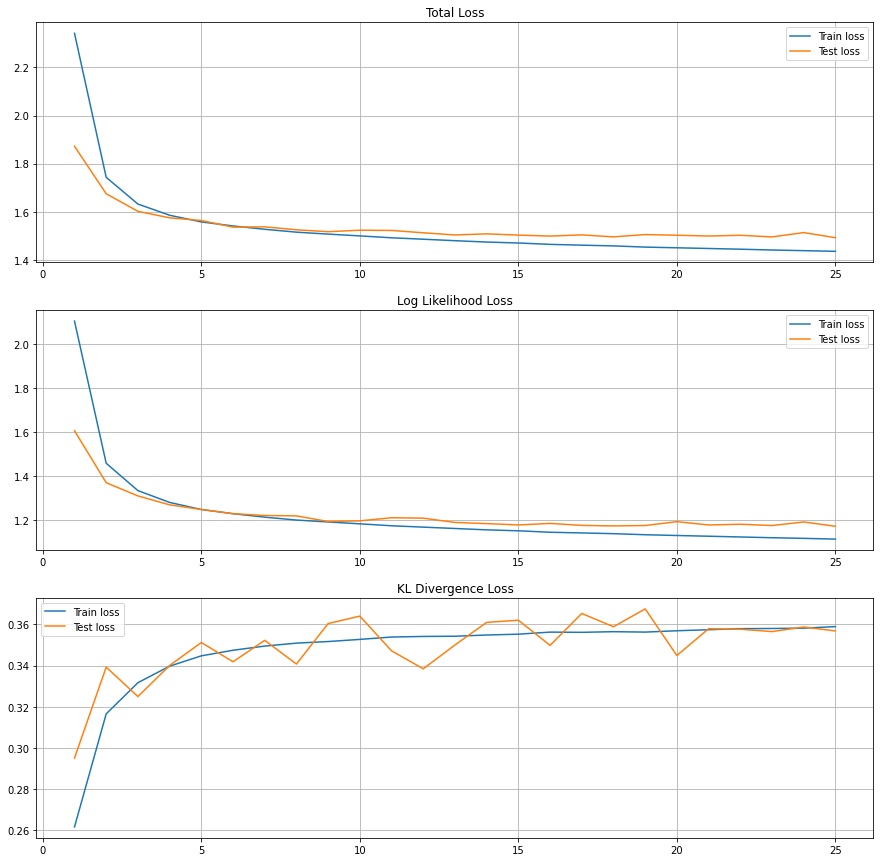

In [ ]:
# *CODE FOR PART 1.2a IN THIS CELL*

fig, axs = plt.subplots(3, 1, figsize=(15,15))
axs[0].plot(list(range(1, 1 + len(losses))), losses)
axs[0].plot(list(range(1, 1 + len(valid_losses))), valid_losses)
axs[0].legend(['Train loss', 'Test loss'])
axs[0].set_title('Total Loss')
axs[0].grid()

axs[1].plot(list(range(1, 1 + len(train_loglike_losses))), train_loglike_losses)
axs[1].plot(list(range(1, 1 + len(valid_loglike_losses))), valid_loglike_losses)
axs[1].legend(['Train loss', 'Test loss'])
axs[1].set_title('Log Likelihood Loss')
axs[1].grid()

axs[2].plot(list(range(1, 1 + len(train_kl_losses))), train_kl_losses)
axs[2].plot(list(range(1, 1 + len(valid_kl_losses))), valid_kl_losses)
axs[2].legend(['Train loss', 'Test loss'])
axs[2].set_title('KL Divergence Loss')
axs[2].grid()


## Part 1.2b: Samples and Reconstructions (6 Points)
Visualize a subset of the images of the test set and their reconstructions **as well as** a few generated samples. Most of the code for this part is provided. You only need to call the forward pass of the model for the given inputs (might vary depending on your implementation).

Input images
--------------------------------------------------
Reconstructed images
--------------------------------------------------
Generated Images
--------------------------------------------------


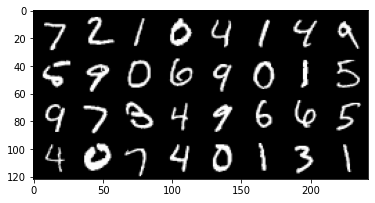

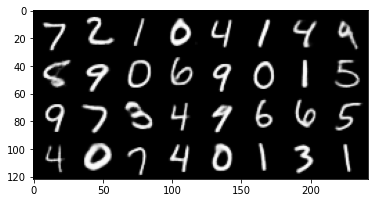

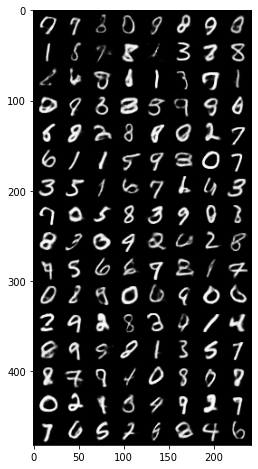

In [ ]:
# *CODE FOR PART 1.2b IN THIS CELL*

# load the model
print('Input images')
print('-'*50)

sample_inputs, _ = next(iter(loader_test))
fixed_input = sample_inputs[0:32, :, :, :]
# visualize the original images of the last batch of the test set
img = make_grid(vae_denorm(fixed_input), nrow=8, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
plt.figure()
show(img)

print('Reconstructed images')
print('-'*50)
with torch.no_grad():
    # visualize the reconstructed images of the last batch of test set
    
    #######################################################################
    #                       ** START OF YOUR CODE **
    #######################################################################
    #######################################################################
    recon_batch, _, _ = model(fixed_input.to(device))
    recon_batch = recon_batch.view(-1, 1, 28, 28)
    #######################################################################
    #                       ** END OF YOUR CODE **
    ####################################################################### 
    
    recon_batch = recon_batch.cpu()
    recon_batch = make_grid(vae_denorm(recon_batch), nrow=8, padding=2, normalize=False,
                            range=None, scale_each=False, pad_value=0)
    plt.figure()
    show(recon_batch)

print('Generated Images')  
print('-'*50)
model.eval()
n_samples = 128
z = torch.randn(n_samples,latent_dim).to(device)
with torch.no_grad():
    #######################################################################
    #                       ** START OF YOUR CODE **
    #######################################################################
    samples = model.decode(z).view(-1, 1, 28, 28)
    #######################################################################
    #                       ** END OF YOUR CODE **
    ####################################################################### 
    
    samples = samples.cpu()
    samples = make_grid(vae_denorm(samples), nrow=8, padding=2, normalize=False,
                            range=None, scale_each=False, pad_value=0)
    plt.figure(figsize = (8,8))
    show(samples)



### Discussion
Provide a brief analysis of your loss curves and reconstructions: 
* What do you observe in the behaviour of the log-likelihood loss and the KL loss (increasing/decreasing)?
* Can you intuitively explain if this behaviour is desirable? Have you observed posterior collapse during traing (i.e. when the KL is too small during the early stages of training)? 
    * If yes, how did you mitigate it? How did this phenomenon reflect on your output samples?
    * If no, why do you think that is?

Accoring to my loss function:
$$
min Loss = -\textbf{E}_{z\sim q_{\phi}(z|x^{(i)})
}[\log{p_{\theta}(x^{(i)}|z)}] + D_{KL}(q_{\phi}(z | x^{(i)})||p_{\theta}(z))
$$
 the total loss should decrease over the train process. And the second curve graph shows that the first term of loss function decreased. The third curve graph show that the KL loss increased.


1. For the first term in loss function, maximize the $-\textbf{E}_{z\sim q_{\phi}(z|x^{(i)})}[\log{p_{\theta}(x^{(i)}|z)}] $, which means to minimize the $\textbf{E}_{z\sim q_{\phi}(z|x^{(i)})}[\log{p_{\theta}(x^{(i)}|z)}] $. And accroding to the second graph, its value was decreasing. So the result(the second graph) is desired.

2. For the second term $ D_{KL}(q_{\phi}(z | x^{(i)})||p_{\theta}(z))$, $p_{\theta}(z)$ from posterior ($p(z|x^{(i)})$) need to be much closer to the prior distribution. Thus the KL-divergence should increase and then become stable. So the output(the third graph) is desired.





The posterior collapse exist. For the early stage of training, the KL is very small and the outputs are some random pictures filled with pixel. The reason might be that the input is too strong. With the strong input, the $μ_d$ and $σ_d$ from the input x are not stable, which will cause the output x' even do not have connection with z. So the output are just pixel.
Letting the epoch between 20 might be a method. Or set beta > 1, which could give pressure to $p_θ(z)$ to be closer to the prior distribution and accelerate the rate of training.


**YOUR ANSWER**

---
<h2> Part 1.3 (11 points) <h2/>

Qualitative analysis of the learned representations

In this question you are asked to qualitatively assess the representations that your model has learned. In particular:

a. Dimensionality Reduction of learned embeddings

b. Interpolating in the latent space

## Part 1.3a: T-SNE on Embeddings (7 Points)
Extract the latent representations of the test set and visualize them using [T-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding)  [(see implementation)](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html). 

We've provided a function to visualize a subset of the data, but you are encouraged to also produce a matplotlib plot (please use different colours for each digit class).

In [ ]:
# *CODE FOR PART 1.3a IN THIS CELL*
from matplotlib import offsetbox
from sklearn.manifold import TSNE

def plot(x, title):
    xmin, xmax = np.min(x, 0), np.max(x, 0)
    x = (x - xmin) / (xmax - xmin)
    plt.figure(figsize=(20,20))
    ax = plt.subplot()

    for i in range(x.shape[0]):
        plt.scatter(x[i, 0], x[i, 1], color=plt.cm.Paired(y[i]/10.))

    if hasattr(offsetbox, 'AnnotationBbox'):
        shown_images = np.array([[1., 1.]]) 
        for i in range(x.shape[0]):
            dist = np.sum((x[i] - shown_images) ** 2, 1)
            if np.min(dist) < 3e-3:
                continue
            shown_images = np.r_[shown_images, [x[i]]]
            imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(test.reshape(-1, 28, 28)[i,:,:],zoom=1),x[i])
            ax.add_artist(imagebox)
    plt.title(title)

In [ ]:
test, X, y = None, None, None
model.eval()
with torch.no_grad():
    # Load test digits and labels
    for batch_idx, data in enumerate(loader_test):
        img, labels = data
        #img = img.view(img.size(0), -1) # Data
        img = img.to(device)
        mu, logvar = model.encode(img)
        test = np.concatenate((test, img.cpu().numpy())) if test is not None else img.cpu().numpy()
        X = np.concatenate((X, mu.cpu().numpy())) if X is not None else mu.cpu().numpy()
        y = np.concatenate((y, labels)) if y is not None else labels

#using sklearn
tsne = TSNE(n_components=2, random_state=1000, init='pca' , verbose=0, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X)



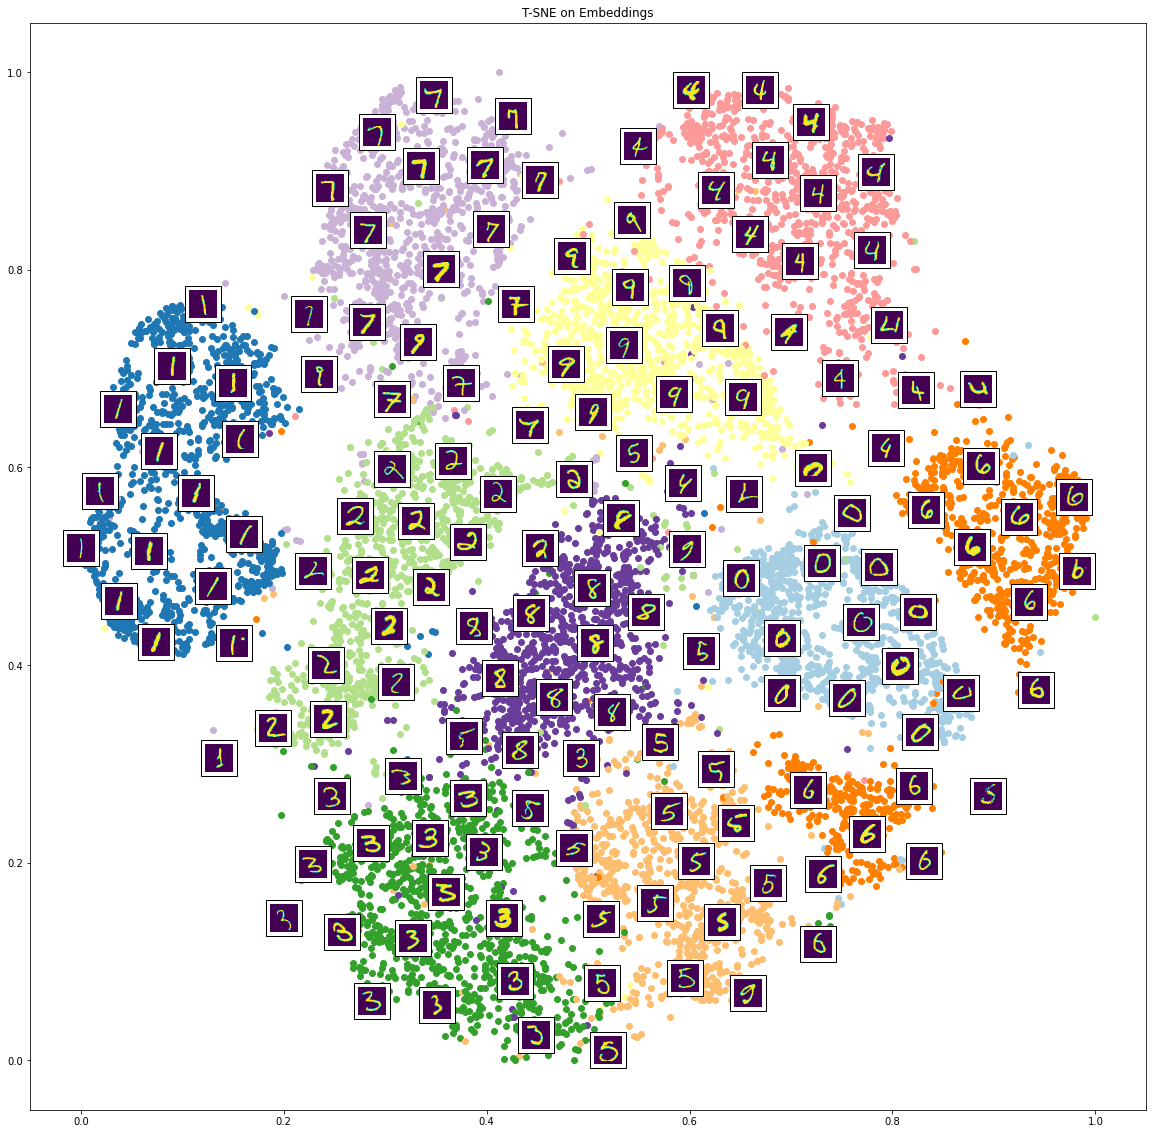

In [ ]:
# Custom Visualizations
# Plotting tsne results using this defined function
plot(tsne_results,"T-SNE on Embeddings" )

### Discussion
What do you observe? Discuss the structure of the visualized representations. 
* What do you observe? What role do the KL loss term and $\beta$ have, if any, in what you observe (multiple matplotlib plots may be desirable here)?
    * Consider Outliers
    * Counsider Boundaries
    * Consider Clusters
* Is T-SNE reliable? What happens if you change the parameters (don't worry about being particularly thorough). [This link](https://distill.pub/2016/misread-tsne/) may be helpful.

I think the T-SNE is reliable. With the T-SNE, the latent data, which dimension is 40, can be projected to a 2D dimension graph. The KL loss term measures the difference between probability distributions. And the beta could be understanded as a pressure. With a suitable pressure, the $ p_θ(z) $ will be colse to the prior distribution.

In this coursework, when β > 1, the outliers become more and more vague. The follwing graph are some other plots with different β.
It can be noticed that the boundaries is not clear with increasing β. And the clusters overlap in the same reason, especially for some similar x. This is because the input is too weak, which means the μ and σ in KL-divergence might disconnect with the input x. μ and σ collapse to constant values, which will lead that the decoder will reconstruct the x' without the z.

As for the cluster and outliers, taking the beta = 0.9 as an example(related to the upper plot). We could noticed the clusters are seperated with each other more clearly than other beta values. With the beta increasing, the clusters have the tend to overlap with each other. And the degree of dispersion is reducing.



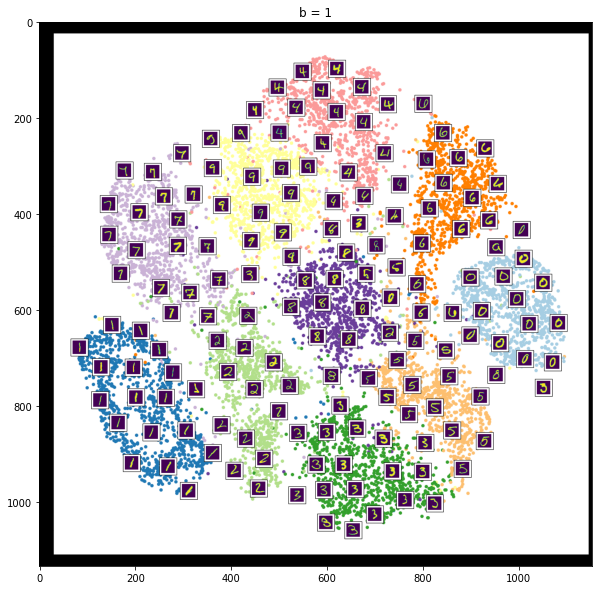

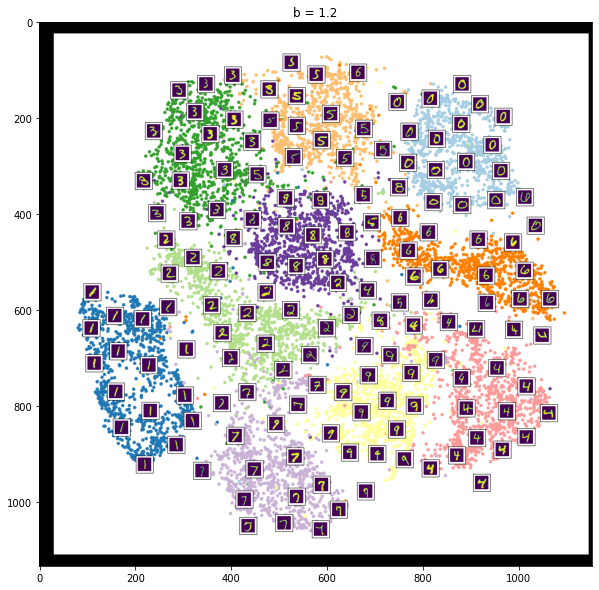

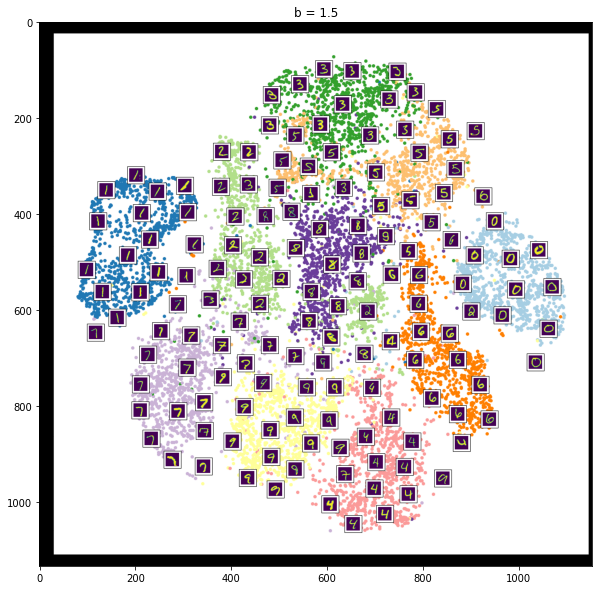

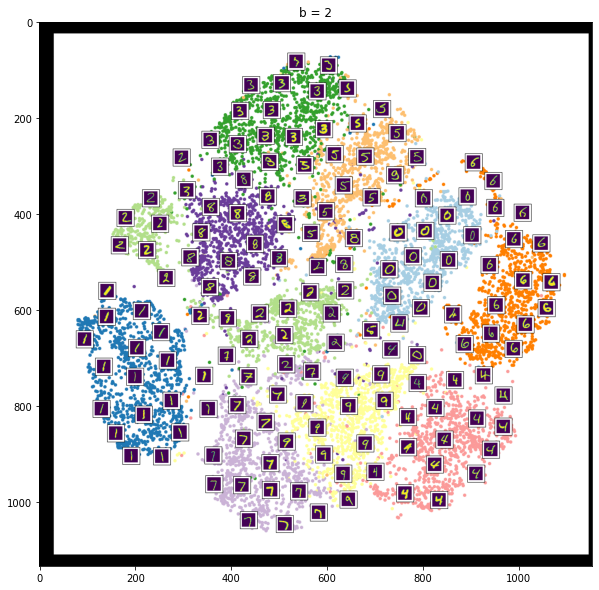

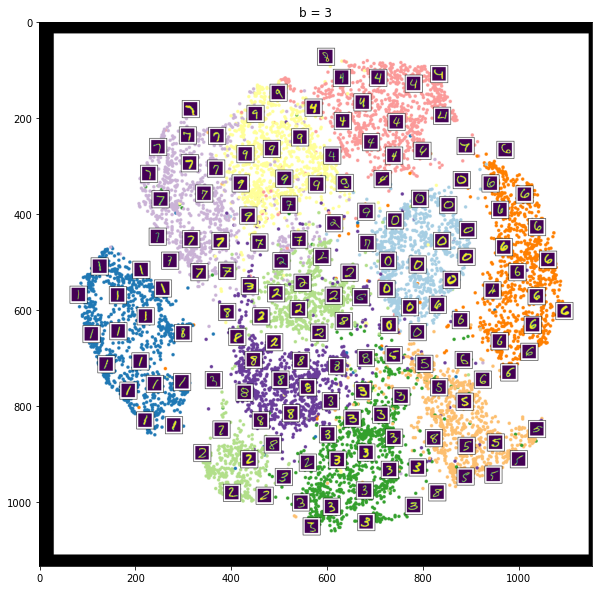

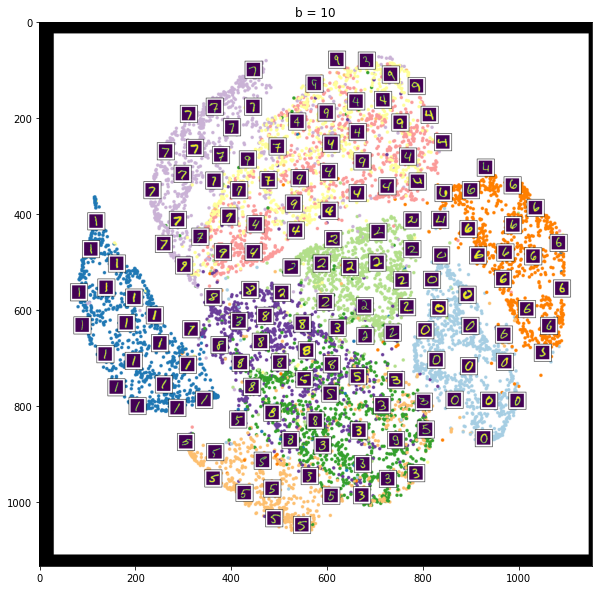

In [ ]:

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('b=1.png')
plt.figure(figsize=(10,10))
plt.title('b = 1')
plt.imshow(img)
plt.show()

img = mpimg.imread('b=1.2.png')
plt.figure(figsize=(10,10))
plt.title('b = 1.2')
plt.imshow(img)
plt.show()

img = mpimg.imread('b=1.5.png')
plt.figure(figsize=(10,10))
plt.title('b = 1.5')
plt.imshow(img)
plt.show()

img = mpimg.imread('b=2.png')
plt.figure(figsize=(10,10))
plt.title('b = 2')
plt.imshow(img)
plt.show()

img = mpimg.imread('b=3.png')
plt.figure(figsize=(10,10))
plt.title('b = 3')
plt.imshow(img)
plt.show()


img = mpimg.imread('b=10.png')
plt.figure(figsize=(10,10))
plt.title('b = 10')
plt.imshow(img)
plt.show()

**YOUR ANSWER**

## Part 1.3b: Interpolating in $z$ (4 Points)
Perform a linear interpolation in the latent space of the autoencoder by choosing any two digits from the test set. What do you observe regarding the transition from on digit to the other?


Interpolation of 0 and 3



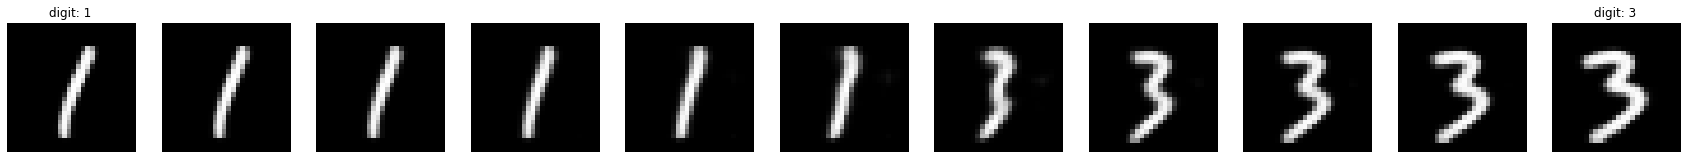

In [ ]:
# CODE FOR PART 1.3b IN THIS CELL

test_data, test_labels = next(iter(loader_test))

x1 = torch.FloatTensor(test_data[30]).reshape(1,1,28,28) # 3
x2 = torch.FloatTensor(test_data[5]).reshape(1,1,28,28) # 0

with torch.no_grad():
    x1 = x1.to(device)
    x2 = x2.to(device)
    mu1, var1 = model.encode(x1)
    mu2, var2 = model.encode(x2)
    z1 = model.reparametrize(mu1, var1)
    z2 = model.reparametrize(mu2, var2)
    a = np.linspace(0,1,num=11)
    interpolated = []
    # Interpolation
    for i in range(len(a)):
        z = a[i] * z1 + (1-a[i]) * z2 
        out = model.decode(z)
        interpolated.append(out)

fig, axs = plt.subplots(1, 11, figsize=(30,30))
print('Interpolation of {} and {}\n'.format(test_labels[25],test_labels[30]))
for i in range(11):
    y = interpolated[i].view(28,28).squeeze().squeeze().cpu().numpy()
    axs[i].imshow(y, cmap='gray')
    axs[i].axis('off')
    if i == 0:
        axs[i].set_title('digit: {} '.format(test_labels[5]))
    elif i == 10:
        axs[i].set_title('digit: {} '.format(test_labels[30]))

### Discussion
What did you observe in the interpolation? Is this what you expected?
* Can you relate the interpolation to your T-SNE visualization

I choose two number : 1 and 3. It is obvious that the leftmost is the most clear 1 and the rightmost is the most clear 3, with the step 0.1.

From the left to right, the number 1 begin to 'bend' to 3. In the middle center image, it could be seen that the '1' is little similar to '3'. It is because that there is a processing from one label distribution to another.

It could be reflected on the T-SNE graph. The process is begun from the cluster 1(upper left), to the cluster 3(lower right).


**YOUR ANSWER**

# Part 2 - Deep Convolutional GAN

In this task, your main objective is to train a DCGAN (https://arxiv.org/abs/1511.06434) on the CIFAR-10 dataset. You should experiment with different architectures, tricks for stability in training (such as using different activation functions, batch normalization, different values for the hyper-parameters, etc.). In the end, you should provide us with: 

- your best trained model (which we will be able to run), 
- some generations for the fixed latent vectors $\mathbf{z}\sim \mathcal{N}\left(\mathbf{0}, \mathbf{I}\right)$ we have provided you with (train for a number of epochs and make sure there is no mode collapse), 
- plots with the losses for the discriminator $D$ and the generator $G$ as the training progresses and explain whether your produced plots are theoretically sensible and why this is (or not) the case. 
- a discussion on whether you noticed any mode collapse, where this behaviour may be attributed to, and explanations of what you did in order to cope with mode collapse. 

## Part 2.1 (30 points)
**Your Task**: 

a. Implement the DCGAN architecture. 

b. Define a loss and implement the Training Loop

c. Visualize images sampled from your best model's generator ("Extension" Assessed on quality)

d. Discuss the experimentations which led to your final architecture. You can plot losses or generated results by other architectures that you tested to back your arguments (but this is not necessary to get full marks).


_Clarification: You should not be worrying too much about getting an "optimal" performance on your trained GAN. We want you to demonstrate to us that you experimented with different types of DCGAN variations, report what difficulties transpired throughout the training process, etc. In other words, if we see that you provided us with a running implementation, that you detail different experimentations that you did before providing us with your best one, and that you have grapsed the concepts, you can still get good marks. The attached model does not have to be perfect, and the extension marks for performance are only worth 10 points._

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
from torch.optim.lr_scheduler import StepLR, MultiStepLR
import torch.nn.functional as F
import matplotlib.pyplot as plt


def gan_denorm(x, channels=None, w=None ,h=None, resize = False):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    if resize:
        if channels is None or w is None or h is None:
            print('Number of channels, width and height must be provided for resize.')
        x = x.view(x.size(0), channels, w, h)
    return x

def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

if not os.path.exists('/content/drive/MyDrive/icl_dl_cw2/CW_VAE'):
    os.makedirs('/content/drive/MyDrive/icl_dl_cw2/CW_VAE')

GPU = True # Choose whether to use GPU
if GPU:
    device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(f'Using {device}')

# We set a random seed to ensure that your results are reproducible.
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

Using cuda


### Part 2.1a: Implement DCGAN (8 Points)
Fill in the missing parts in the cells below in order to complete the Generator and Discriminator classes. You will need to define:

- The hyperparameters
- The constructors
- `decode`
- `discriminator`

Recomendations for experimentation:
- use the architecture that you implemented for the Autoencoder of Part 1 (encoder as discriminator, decoder as generator).
- use the architecture desribed in the DCGAN paper (https://arxiv.org/abs/1511.06434).

Some general reccomendations:
- add several convolutional layers (3-4).
- accelerate training with batch normalization after every convolutional layer.
- use the appropriate activation functions. 
- Generator module: the upsampling can be done with various methods, such as nearest neighbor upsampling (`torch.nn.Upsample`) or transposed convolutions(`torch.nn.ConvTranspose2d`). 
- Discriminator module: Experiment with batch normalization (`torch.nn.BatchNorm2d`) and leaky relu (`torch.nn.LeakyReLu`) units after each convolutional layer.

Try to follow the common practices for CNNs (e.g small receptive fields, max pooling, RELU activations), in order to narrow down your possible choices.

<font color="red">**Your model should not have more than 25 Million Parameters**</font>

The number of epochs that will be needed in order to train the network will vary depending on your choices. As an advice, we recommend that while experimenting you should allow around 20 epochs and if the loss doesn't sufficiently drop, restart the training with a more powerful architecture. You don't need to train the network to an extreme if you don't have the time.

#### Data loading

In [ ]:
batch_size = 128  # change that

transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5),),                        
])

data_dir = './datasets'

cifar10_train = datasets.CIFAR10(data_dir, train=True, download=True, transform=transform)
cifar10_test = datasets.CIFAR10(data_dir, train=False, download=True, transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=batch_size)
loader_test = DataLoader(cifar10_test, batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


We'll visualize a subset of the test set: 

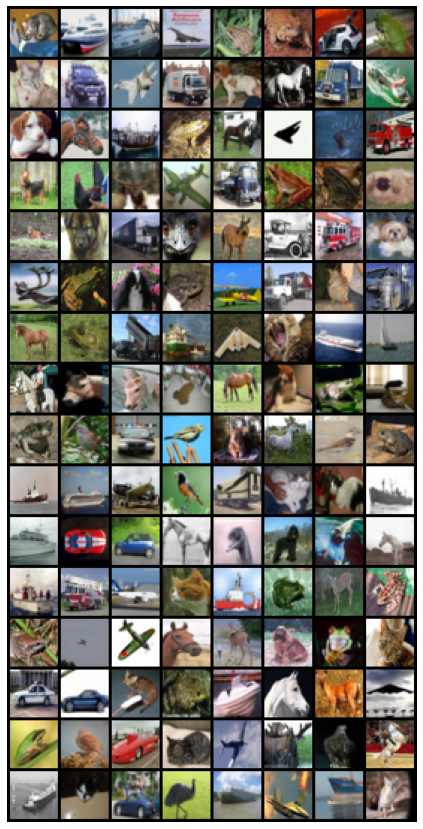

In [ ]:
samples, _ = next(iter(loader_test))

samples = samples.cpu()
samples = make_grid(gan_denorm(samples), nrow=8, padding=2, normalize=False,
                        range=None, scale_each=False, pad_value=0)
plt.figure(figsize = (15,15))
plt.axis('off')
show(samples)

#### Model Definition
Define hyperparameters and the model

In [ ]:
# *CODE FOR PART 2.1 IN THIS CELL*

# Choose the number of epochs, the learning rate
# and the size of the Generator's input noise vetor.

num_epochs = 71
learning_rate =0.0002
latent_vector_size = 100

# Other hyperparams
image_dim = 32

In [ ]:
# *CODE FOR PART 2.1 IN THIS CELL*


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        self.deconv1 = nn.Sequential(
            nn.ConvTranspose2d(latent_vector_size, image_dim * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(image_dim * 16),
            nn.ReLU(True)
        )

        #self.drop1 = nn.Dropout2d(0.2)
        # (512, 4, 4)
        self.deconv2 = nn.Sequential(
            nn.ConvTranspose2d(image_dim * 16, image_dim * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(image_dim * 8),
            nn.ReLU(True)
        )
        #  (256, 8, 8)

        # (256, 8, 8)
        self.deconv3 = nn.Sequential(
            nn.ConvTranspose2d(image_dim * 8, image_dim * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(image_dim * 4),
            nn.ReLU(True)
        ) 
        # (128, 16, 16)
        
        # (128, 16, 16)
        self.deconv4 = nn.Sequential(
            nn.ConvTranspose2d(image_dim * 4, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )
        #  (3, 32, 32)

        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 


    def forward(self, z):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        x = self.deconv1(z)
        #x = self.drop1(x)
        x = self.deconv2(x)
        x = self.deconv3(x)
        out = self.deconv4(x)
        
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################
        return out


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        #(3, 32, 32)
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, image_dim * 4, 4, 2, 1, bias=False),
            #nn.BatchNorm2d(image_dim * 4),
            nn.LeakyReLU(0.2, inplace = True)
        )
        #  (128, 16, 16)

        self.drop1 = nn.Dropout2d(0.05)

        # (128, 16, 16)
        self.conv2 = nn.Sequential(
            nn.Conv2d(image_dim * 4, image_dim * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(image_dim * 8),
            nn.LeakyReLU(0.2, inplace = True)
        )
        # (256, 8, 8)
        
        self.drop2 = nn.Dropout2d(0.2)

        # (256, 8, 8)
        self.conv3 = nn.Sequential(
            nn.Conv2d(image_dim * 8, image_dim * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(image_dim * 16),
            nn.LeakyReLU(0.2, inplace = True)
        )
        # (512, 4, 4)

        self.drop3 = nn.Dropout2d(0.2)

        # (512, 4, 4)
        self.conv4 = nn.Sequential(
            nn.Conv2d(image_dim * 16, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        # (1, 1, 1)
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        
    def forward(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        x = self.conv1(x)
        x = self.drop1(x)

        x = self.conv2(x)
        #x = self.drop2(x)

        x = self.conv3(x)

        out = self.conv4(x)
        
        return out
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        


<h2> Initialize Model and print number of parameters </h2>

You can use method `weights_init` to initialize the weights of the Generator and Discriminator networks. Otherwise, implement your own initialization, or do not use at all. You will not be penalized for not using initialization.

In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [ ]:
use_weights_init = True

model_G = Generator().to(device)
if use_weights_init:
    model_G.apply(weights_init)
params_G = sum(p.numel() for p in model_G.parameters() if p.requires_grad)
print("Total number of parameters in Generator is: {}".format(params_G))
print(model_G)
print('\n')

model_D = Discriminator().to(device)
if use_weights_init:
    model_D.apply(weights_init)
params_D = sum(p.numel() for p in model_D.parameters() if p.requires_grad)
print("Total number of parameters in Discriminator is: {}".format(params_D))
print(model_D)
print('\n')

print("Total number of parameters is: {}".format(params_G + params_D))

Total number of parameters in Generator is: 3448576
Generator(
  (deconv1): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (deconv2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (deconv3): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (deconv4): Sequential(
    (0): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): Tanh()
  )
)


Total number of parameters in Discriminator is: 2637312
Discriminator(
  

### Part 2.1b: Training the Model (12 Points)

#### Defining a Loss

In [ ]:
criterion = nn.BCELoss(reduction='mean')
def loss_function(out, label):
    loss = criterion(out, label)
    return loss

<h3>Choose and initialize optimizers</h3>

In [ ]:
# setup optimizer
# You are free to add a scheduler or change the optimizer if you want. We chose one for you for simplicity.
beta1 = 0.5
optimizerD = torch.optim.Adam(model_D.parameters(), lr=learning_rate/2.0, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(model_G.parameters(), lr=learning_rate/1.0, betas=(beta1, 0.999))
schedulerG = torch.optim.lr_scheduler.StepLR(optimizerG, step_size=10, gamma=0.7)

<h3> Define fixed input vectors to monitor training and mode collapse. </h3>

In [ ]:
fixed_noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)
real_label = 0.9
fake_label = 0.1

#### Training Loop

In [ ]:
import matplotlib.pyplot as plt

train_losses_G = []
train_losses_D = []

for epoch in range(num_epochs):
    train_loss_D = 0
    train_loss_G = 0
    for i, data in enumerate(loader_train, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################device
        # train with real

        model_D.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)

        label = torch.full((batch_size,), real_label, device=device)
        output = model_D(real_cpu).view(-1, 1).squeeze(1)

        output = output.to(torch.float32)
        label = label.to(torch.float32)


        errD_real = loss_function(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)
        fake = model_G(noise)

        label.fill_(fake_label)
        
        output = model_D(fake.detach()).view(-1, 1).squeeze(1)
        errD_fake = loss_function(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        train_loss_D += errD.item()
        optimizerD.step()



        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        
        model_G.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = model_D(fake).view(-1, 1).squeeze(1)
        errG = loss_function(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        train_loss_G += errG.item()
        optimizerG.step()

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, num_epochs, i, len(loader_train),
                 errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

    if epoch == 0:
        save_image(gan_denorm(real_cpu.cpu()).float(), '/content/drive/MyDrive/icl_dl_cw2/CW_VAE/real_samples.png')
    with torch.no_grad():
        fake = model_G(fixed_noise)
        save_image(gan_denorm(fake.cpu()).float(), '/content/drive/MyDrive/icl_dl_cw2/CW_VAE/fake_samples_epoch_%03d.png' % epoch)
    train_losses_D.append(train_loss_D / len(loader_train))
    train_losses_G.append(train_loss_G / len(loader_train))

    if (epoch + 1) % 3 == 0:
        plt.plot(list(range(0, np.array(train_losses_D).shape[0])), np.array(train_losses_D), label='loss_D')
        plt.plot(list(range(0, np.array(train_losses_G).shape[0])), np.array(train_losses_G), label='loss_G')
        plt.legend()
        plt.title('Train Losses')
        plt.grid()
        plt.show()

    schedulerG.step()
    
# save  models 
# if your discriminator/generator are conditional you'll want to change the inputs here
torch.jit.save(torch.jit.trace(model_G, (fixed_noise)), '/content/drive/MyDrive/icl_dl_cw2/CW_VAE/GAN_G_model.pth')
torch.jit.save(torch.jit.trace(model_D, (fake)), '/content/drive/MyDrive/icl_dl_cw2/CW_VAE/GAN_D_model.pth')



[0/71][0/391] Loss_D: 1.6039 Loss_G: 2.4717 D(x): 0.5746 D(G(z)): 0.5479 / 0.0938
[0/71][1/391] Loss_D: 2.5049 Loss_G: 1.6035 D(x): 0.6083 D(G(z)): 0.8210 / 0.2331
[0/71][2/391] Loss_D: 2.7783 Loss_G: 1.5692 D(x): 0.5392 D(G(z)): 0.8496 / 0.2283
[0/71][3/391] Loss_D: 2.5328 Loss_G: 2.0907 D(x): 0.5125 D(G(z)): 0.8007 / 0.1293
[0/71][4/391] Loss_D: 2.4901 Loss_G: 2.4409 D(x): 0.4670 D(G(z)): 0.7451 / 0.0954
[0/71][5/391] Loss_D: 2.3837 Loss_G: 2.7244 D(x): 0.4667 D(G(z)): 0.7273 / 0.0711
[0/71][6/391] Loss_D: 2.3384 Loss_G: 3.1231 D(x): 0.4443 D(G(z)): 0.6833 / 0.0489
[0/71][7/391] Loss_D: 2.3941 Loss_G: 3.4284 D(x): 0.4288 D(G(z)): 0.6975 / 0.0347
[0/71][8/391] Loss_D: 2.2806 Loss_G: 3.7082 D(x): 0.4571 D(G(z)): 0.6604 / 0.0257
[0/71][9/391] Loss_D: 2.4807 Loss_G: 3.8030 D(x): 0.4487 D(G(z)): 0.7225 / 0.0266
[0/71][10/391] Loss_D: 2.1036 Loss_G: 4.1298 D(x): 0.4573 D(G(z)): 0.6069 / 0.0187
[0/71][11/391] Loss_D: 2.0480 Loss_G: 4.2399 D(x): 0.4391 D(G(z)): 0.5316 / 0.0136
[0/71][12/391]

KeyboardInterrupt: ignored

## Part 2.1c: Results (10 Points)
This part is fairly open-ended, but not worth too much so do not go crazy. The table below shows examples of what are considered good samples. Level 3 and above will get you 10/10 points, level 2 will roughly get you 5/10 points and level 1 and below will get you 0/10 points.

<table><tr>
<td> 
  <p align="center" style="padding: 10px">
    <img alt="Forwarding" src="https://drive.google.com/uc?id=1wQ2f10-A1Vs7k0LMfBPPyYTsPlkBF9QE" width="%30">
    <br>
    <em style="color: grey">Level 1</em>
  </p> 
</td>
<td> 
  <p align="center">
    <img alt="Routing" src="https://drive.google.com/uc?id=1wlDhX4hROET4s8Ndxn8nhj_0RLM2rnuG" width="%30">
    <br>
    <em style="color: grey">Level 2</em>
  </p> 
</td>
<td> 
  <p align="center">
    <img alt="Routing" src="https://drive.google.com/uc?id=1w9VrgfJLCRaTPhwoFVYdYhtCeaQmFHGb" width="%30">
    <br>
    <em style="color: grey">Level 3</em>
  </p> 
</td>
</tr></table>

### Generator samples

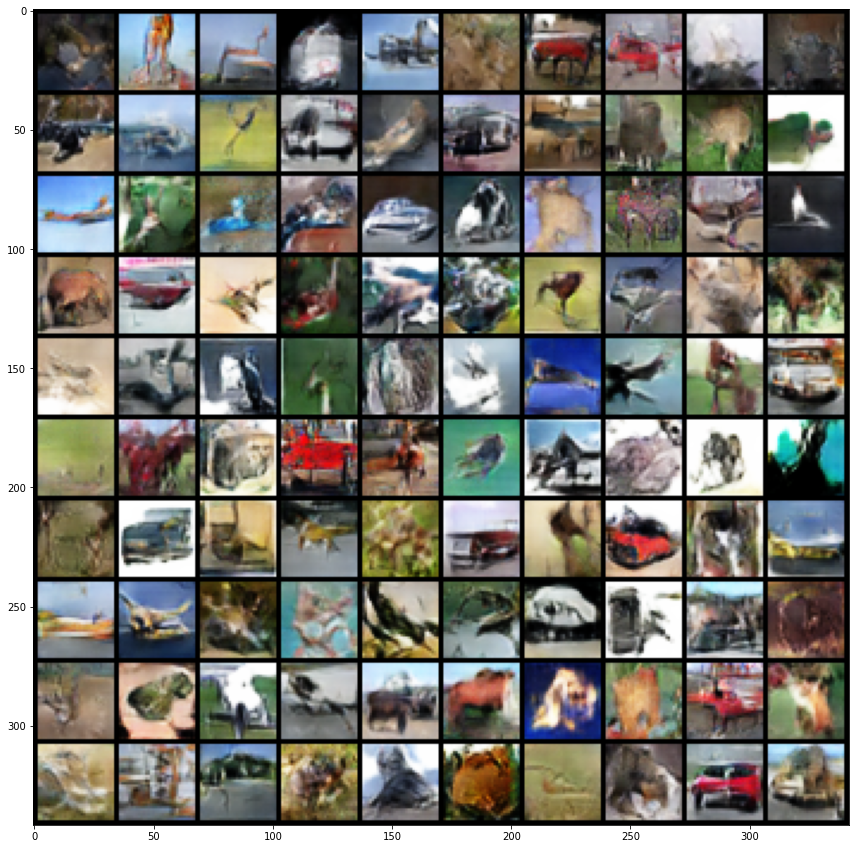

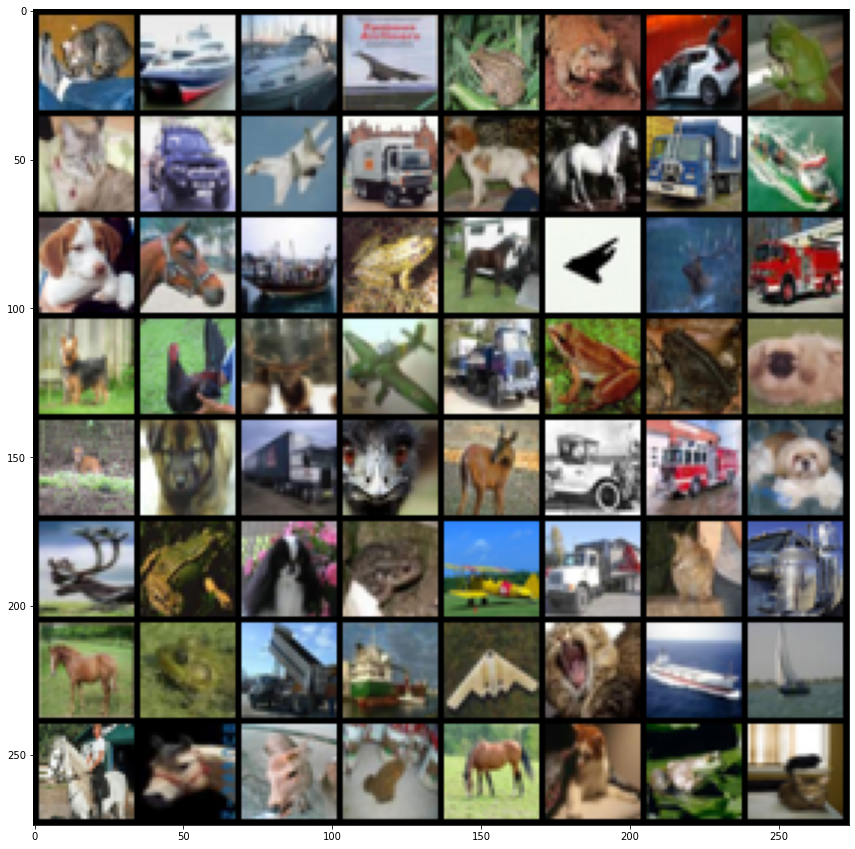

In [ ]:
input_noise = torch.randn(128, latent_vector_size, 1, 1, device=device)
with torch.no_grad():
    # visualize the generated images
    generated = model_G(input_noise).cpu()
    generated = make_grid(gan_denorm(generated)[:100], nrow=10, padding=2, normalize=False, 
                        range=None, scale_each=False, pad_value=0)
    plt.figure(figsize=(15,15))
    save_image(generated,'/content/drive/MyDrive/icl_dl_cw2/CW_GAN/Teaching30final.png')
    show(generated) # note these are now class conditional images columns rep classes 1-10

it = iter(loader_test)
sample_inputs, _ = next(it)
fixed_input = sample_inputs[0:64, :, :, :]
# visualize the original images of the last batch of the test set for comparison
img = make_grid(gan_denorm(fixed_input), nrow=8, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
plt.figure(figsize=(15,15))
show(img)

## Part 2.1d: Engineering Choices (10 Points)

Discuss the process you took to arrive at your final architecture. This should include:

* Which empirically useful methods did you utilize
* What didn't work, what worked and what mattered most
* Are there any tricks you came across in the literature etc. which you suspect would be helpful here




**Your Answer**


It is a really sad story between me and DCGAN. I even do not know how to answer the question.

**1.empirically methods: (the result tell me, all my methods are bad methods.)**

a.the activation functions need to relate the output. It is necessary to use sigmoid(probability output) in the discriminator output layer, and Tanh(-1,+1) in generator output layer.

b.set a small learning rate at the begining. 0.0001 might be the god, forever.

c.Try different epoch at least once. In this coursework, taking the epoch = 20 need a lot of time, but taking the epoch = 50, the loss will begin a new trend, which is worth for taking more time for just a try.

d.Always try the learning rate scheduler. In this coursework, it save me a lot of time for training, though the result is very bad.





**2.What didn't work, what worked and what mattered most.**

a. Batch Normalization worked very well when I added to my net. It improve the quality of output directly because it could avoid the mode collapse.

b. Fully connection layers did not have any postive affect in this coursework. 

c. Adding the dropout2d to the discriminator first output layer is useful to accelerate the converge at the early training. But adding the dropout2d to both generator and discriminator is not useful for my net(might be useful for other). And the dropout rate cannot be so huge. I set it as 0.5 at first, then the loss of discriminator and the loss of generator wanted to fly to the sky.

d. For the generator, the output need to be ($3*32*32$), the 3 means the channels of RGB image. It is necessary to use ReLU to avoid the vanishing gradients.

e. For the Discriminator, the leakey ReLU is useful because it allows small gradients for negative inputs.

**3.Are there any tricks you came across in the literature etc. which you suspect would be helpful here.**

a.Batch Normalization standardizes to a zero mean and unit variance, which is useful to improve DCGAN. But I did not use it in generator output layer and discriminator input layer to avoid sample oscillation and model instability.

b.Dropout function is very magical when I design the network at the begining. At that time my GAN never had converge trend. But with the dropout2d(0.5), it converged at once. And I noticed that the reason why the network did not converge is because my net was too complex. When I simplify it, with the dropout, something dangerous happened: the loss of discriminator is higher than the generator. Then I deleted the dropout, and the net became very stable!

c.Learning rate scheduler help me accelerate the rate of training. For each 10 epoch, the rate will decrease and the loss of discriminator will be more close to 0.5, the loss of generator will increase but not bigger than 2.

d.Drawing the loss graph every 3 epoch can save a huge amount of time. You cannot believe that I used some fully connected layers at the begging. And the output was very very dangerous. Because the net need much time for training. I draw the loss graph for every 3 epoch to observe the trend. I noticed that no matter how I change the parameter of net, I could never fix the hell output and the hell loss curves(both of them wanted to fly). But according to the little graph, I do not cost many time to notice that fully connected layers are very bad.

e.label smoothing: I think let the real label = 0.9 and the fake label =0.1 might be helpful for avoiding extreme extrapolation

f.learning rate scheduler: This save my time again. I think it is useful to decrease the learning rate for every 10 epoch during the whole training process. With it, the loss of discriminator would decrease. But it seems not reliable if I have enough time for training it.




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: ignored

## Part 2.2: Understanding GAN Training (5 points)


### Loss Curves
**Your task:**


Plot the losses curves for the discriminator $D$ and the generator $G$ as the training progresses and explain whether the produced curves are theoretically sensible and why this is (or not) the case (x-axis: epochs, y-axis: loss).

Make sure that the version of the notebook you deliver includes these results.

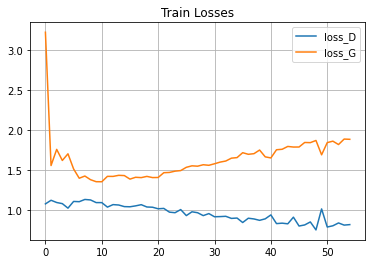

In [ ]:
# ANSWER FOR PART 2.2 IN THIS CELL*

import matplotlib.pyplot as plt
plt.plot(list(range(0, np.array(train_losses_D).shape[0])), np.array(train_losses_D), label='loss_D')
plt.plot(list(range(0, np.array(train_losses_G).shape[0])), np.array(train_losses_G), label='loss_G')
plt.legend()
plt.title('Train Losses')
plt.grid()
plt.show()


### Discussion

Do your loss curves look sensible? What would you expect to see and why?


For each backpropagation, generator will update all the weights, and with some random noise, learn how to reproduce the data. 

So at the early training stage, the loss of the Generator decreased quickly, which is desired. And in the later training process, the loss of GAN was converge to a number between 1.5 to 2.0. From the experience, the trend is normal.

The loss of discriminator increase at very early training stage(epoch = 1), which is corresspending to the decreasing of generator loss. In the end, the discriminator have a trend to decrease to the 0.5, which is also we want. (the notebook meet an error that there are only 55 epoch. F*** CHINA VPN!)

The generator converge to a value around 2 and the discriminator converge to 0.5 might be the best end. But there is no time for me. I have to struggle with other coursework.



**YOUR ANSWER**

## Part 2.3: Understanding Mode Collapse (5 points) 
**Your task:** 

Based on the images created by your generator using the `fixed_noise` vector during training, provide a discussion on whether you noticed any mode collapse, what this behaviour may be attributed to, and explain what you did in order to cope with mode collapse.

In [ ]:
# Any additional code

### Discussion
Mode collapse is when the generator outputs limited varieties of samples, which cannot capture enough "modes" of data features.

From what I think. The GAN is an adversarial game between min and max. If the generator becomes so good at generating a small set of samples that are virtually indistinguishable from the real data, the discriminator will be confused every time. The collapse happens when the generator network generates the sample much eaiser, which let the discriminator think it is real.

Since this is an adversarial (min-max) game, the two losses of the two networks will eventually converge . If the generator becomes so good at generating a small set  of samples that are virtually indistinguishable from the real data, this will actually fool the discriminator every time. So mode collapse happens when it’s easier for the generator network to generate a sample(s) which look(s) real and fool the discriminator.
For example: $$\overline{x}=G(z)=\arg \max D(x)$$ in order to minimise $$\mathbb{E}_{z \sim p(z)}[\log(1-D(G(z)))]$$

I use a lot of parameters to tune the DCGAN. The Batch normalization normalise the input features of the layer to zero mean and unit variance, which is very useful.

**YOUR ANSWER**



# TA Test Cell
TAs will run this cell to ensure that your results are reproducible, and that your models have been defined suitably. 

<font color="blue"> <b> Please provide the input and output transformations required to make your VAE and GANs work. If your GAN generator requires more than just noise as input, also specify this below (there are two marked cells for you to inspect) </b></font>


In [ ]:
# If you want to run these tests yourself, change directory:
# !cd /content/drive/MyDrive/icl_dl_cw2/

In [ ]:
!pip install -q torch torchvision

In [ ]:
# Do not remove anything here
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt 

show = lambda img: plt.imshow(np.transpose(img.cpu().numpy(), (1,2,0)))

device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")

# Do not change this cell!
torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

In [ ]:
############# CHANGE THESE (COPY AND PASTE FROM YOUR OWN CODE) #############
vae_transform = transforms.Compose([
    transforms.ToTensor(),
])

vae_denorm = lambda x : x

def gan_denorm(x, channels=None, w=None ,h=None, resize = False):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    if resize:
        if channels is None or w is None or h is None:
            print('Number of channels, width and height must be provided for resize.')
        x = x.view(x.size(0), channels, w, h)
    return x

gan_latent_size = 100

# If your generator requires something other than noise as input, please specify
# two cells down from here

In [ ]:
# Load VAE Dataset
test_dat = datasets.MNIST("./data/", train=False, transform=vae_transform, 
                          download=True)
vae_loader_test = DataLoader(test_dat, batch_size=32, shuffle=False)

In [ ]:
############# MODIFY IF NEEDED #############
sample_inputs, _ = next(iter(vae_loader_test))
vae_input = sample_inputs[0:32, :, :, :]

# If your generator is conditional, then please modify this input suitably
input_noise = torch.randn(128, gan_latent_size, 1, 1, device=device)
gan_input = [input_noise] # In case you want to provide a tuple, we wrap ours

Used Convs
Used Convs


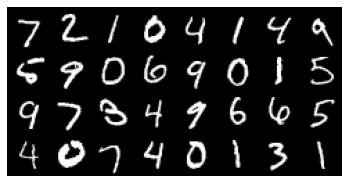

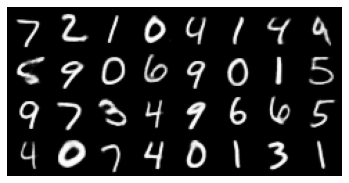

In [ ]:
# VAE Tests
# TAs will change these paths as you will have provided the model files manually
"""To TAs, you should have been creating a folder with the student uid
   And the .ipynb + models in the root. Then that path is './VAE_model.pth' etc.
"""
vae = model_G = torch.jit.load('/content/drive/MyDrive/icl_dl_cw2/CW_VAE/VAE_model.pth')
vae.eval()

# Check if VAE is convolutional

for module in vae.children():
    for layer in module.children():
        if "Conv2d" in layer.original_name:
            print("Used Convs")
            break



vae_in = make_grid(vae_denorm(vae_input), nrow=8, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
plt.figure()
plt.axis('off')
show(vae_in)


    # visualize the reconstructed images of the last batch of test set
    
    #######################################################################
    #                       ** START OF YOUR CODE **
    #######################################################################
    #######################################################################

    #recon_batch, _, _ = model(fixed_input.to(device))
    #recon_batch = recon_batch.view(-1, 1, 28, 28)

    #######################################################################
    #                       ** END OF YOUR CODE **
    ####################################################################### 
    
    #recon_batch = recon_batch.cpu()
    #recon_batch = make_grid(denorm(recon_batch), nrow=8, padding=2, normalize=False,
    #                        range=None, scale_each=False, pad_value=0)
    #plt.figure()
    #show(recon_batch)


vae_test = vae(vae_input.to(device))[0].detach()
vae_test = vae_test.view(-1,1,28,28)

vae_reco = make_grid(vae_denorm(vae_test), nrow=8, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
plt.figure()
plt.axis('off')
show(vae_reco)

Number of Parameters is 6085888 which is ok


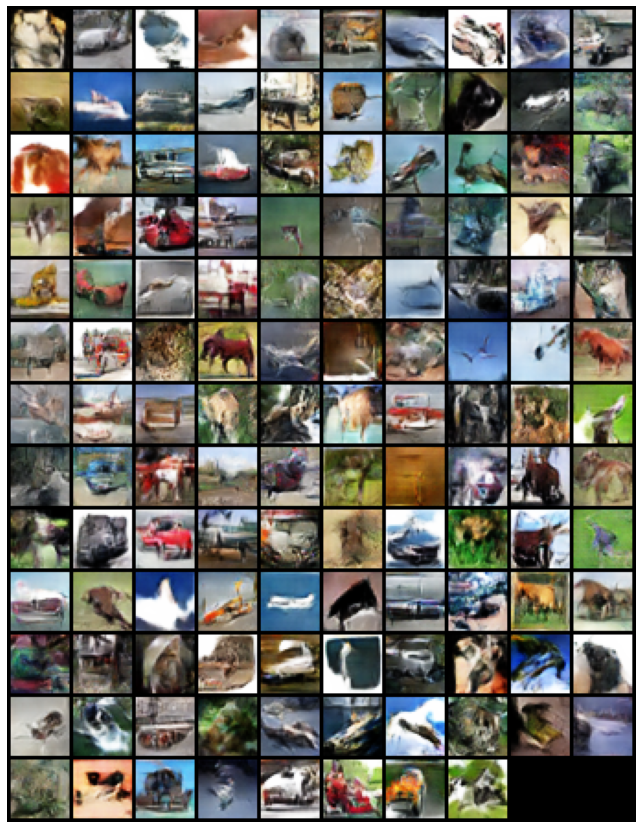

In [ ]:
# GAN Tests
input_noise = torch.randn(128, 100, 1, 1, device=device)
gan_input = [input_noise] # In case you want to provide a tuple, we wrap ours


model_G = torch.jit.load('/content/drive/MyDrive/icl_dl_cw2/CW_GAN/GAN_G_model.pth')
model_D = torch.jit.load('/content/drive/MyDrive/icl_dl_cw2/CW_GAN/GAN_D_model.pth')
[model.eval() for model in (model_G, model_D)]  

# Check that GAN doesn't have too many parameters
num_param = sum(p.numel() for p in [*model_G.parameters(),*model_D.parameters()])

print(f"Number of Parameters is {num_param} which is", "ok" if num_param<25E+6 else "not ok")

# visualize the generated images
generated = model_G(*gan_input).cpu()
#generated = model_G(input_noise).cpu()

generated = make_grid(gan_denorm(generated)[:150].detach(), nrow=10, padding=2, normalize=False, 
                    range=None, scale_each=False, pad_value=0)
plt.figure(figsize=(15,15))
plt.axis('off')
show(generated)